# License_Plate_Detection_Pytorch

This is a two stage lightweight and robust license plate recognition in MTCNN and LPRNet using Pytorch. MTCNN is a very well-known real-time detection model primarily designed for human face recognition. It is modified for license plate detection. LPRNet, another real-time end-to-end DNN, is utilized for the subsquent recognition. This network is attributed by its superior performance with low computational cost without preliminary character segmentation. The Spatial Transformer Layer is embeded in this work to allow a better characteristics for recognition. The recognition accuracy is up to 99% on CCPD base dataset with ~ 80 ms/image on Nivida Quadro P4000. Here is the illustration of the proposed pipeline:

<img src="test/pipeline.png"  width="600" style="float: left;">

## MTCNN 

The modified MTCNN structure is presented as below. Only proposal net (Pnet) and output net (Onet) are used in this work since it is found that skipping Rnet will not hurt the accuracy in this case. The Onet accepts 24(height) x 94(width) BGR image which is consistent with input for LPRNet.

<img src="test/MTCNN.png"  width="600" style="float: left;">

The MTCNN test code is shown as below: 

In [1]:
import sys
sys.path.append('./LPRNet')
sys.path.append('./MTCNN')
from LPRNet_Test import *
from MTCNN import *
import numpy as np
import argparse
import torch
import time
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image = cv2.imread('test/7.jpg')
input = np.copy(image)
bboxes = create_mtcnn_net(input, (50, 15), device, p_model_path='MTCNN/weights/pnet_Weights', o_model_path='MTCNN/weights/onet_Weights')

for i in range(bboxes.shape[0]):

    bbox = bboxes[i, :4]
    x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
    cv2.rectangle(input, (x1, y1), (x2, y2), (0, 0, 255), 10)

Visualize the Image

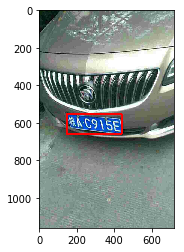

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(input[:,:,::-1])
plt.rcParams['figure.figsize']=(15, 14)
plt.show()

## Spatial Transformer Networks 

The spatial transformer network is a type of a visual attention mechanism. It allows a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. Please refer to [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) for detailed information 

torch.Size([1, 3, 24, 94])


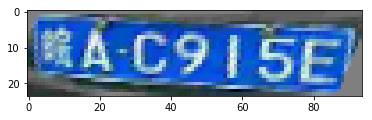

In [3]:
def convert_image(inp):
    # convert a Tensor to numpy image
    inp = inp.squeeze(0).cpu()
    inp = inp.detach().numpy().transpose((1,2,0))
    inp = 127.5 + inp/0.0078125
    inp = inp.astype('uint8') 

    return inp

STN = STNet()
STN.to(device)
STN.load_state_dict(torch.load('LPRNet/weights/Final_STN_model.pth', map_location=lambda storage, loc: storage))
STN.eval()

bbox = bboxes[0, :4]
x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
w = int(x2 - x1 + 1.0)
h = int(y2 - y1 + 1.0)
img_box = np.zeros((h, w, 3))
img_box = image[y1:y2+1, x1:x2+1, :]
im = cv2.resize(img_box, (94, 24), interpolation=cv2.INTER_CUBIC)
im = (np.transpose(np.float32(im), (2, 0, 1)) - 127.5)*0.0078125
data = torch.from_numpy(im).float().unsqueeze(0).to(device)  # torch.Size([1, 3, 24, 94]) 
transfer = STN(data)
print(transfer.shape)
transformed_img = convert_image(transfer)

plt.imshow(transformed_img[:,:,::-1])
plt.show()

## LPRNet architecture 

The basic building block of the model backbone was inspired by SqueezeNet Fire Blocks and Inception Blocks. The input image size is set as 94x24 pixels RGB image. The image is preprocessed by the Spatial Transformer Layer to allow better characteristics. The converted RGB image goes through the backbone and the intermediate feature maps from backbone subnet outputs are utiltized to capture important characteristics instead of using LSTM. The intermediate feature maps are augmented with the global context embedding and concatenated together. In order to adjust the depth of feature map to the character class number, additional 1x1 convolution is applied. The model output and the target character sequence lengths are of different length. Here we use length of 18 as output, for each output character, there are 68 different classes resulting from the CHARS. 

In [4]:
import torch.nn as nn
import torch

class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(), #13
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=256+class_num+128+64, out_channels=self.class_num, kernel_size=(1,1), stride=(1,1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                print("intermediate feature map {} shape is: ".format(i), x.shape)
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            print("after globel context {} shape is: ".format(i), f.shape)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        print("after container shape is: ", x.shape)
        logits = torch.mean(x, dim=2)

        return logits
    
CHARS = ['京', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑',
     '苏', '浙', '皖', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤',
     '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁',
     '新',
     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
     'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
     'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
     'W', 'X', 'Y', 'Z', 'I', 'O', '-'
     ]

In [5]:
lprnet = LPRNet(class_num=len(CHARS), dropout_rate=0)
lprnet.to(device)
lprnet.load_state_dict(torch.load('LPRNet/weights/Final_LPRNet_model.pth', map_location=lambda storage, loc: storage))
lprnet.eval()
preds = lprnet(transfer)
print("output shape is: ", preds.shape)

intermediate feature map 2 shape is:  torch.Size([1, 64, 22, 92])
intermediate feature map 6 shape is:  torch.Size([1, 128, 20, 90])
intermediate feature map 13 shape is:  torch.Size([1, 256, 18, 44])
intermediate feature map 22 shape is:  torch.Size([1, 68, 4, 18])
after globel context 0 shape is:  torch.Size([1, 64, 4, 18])
after globel context 1 shape is:  torch.Size([1, 128, 4, 18])
after globel context 2 shape is:  torch.Size([1, 256, 4, 18])
after globel context 3 shape is:  torch.Size([1, 68, 4, 18])
after container shape is:  torch.Size([1, 68, 4, 18])
output shape is:  torch.Size([1, 68, 18])


## Decoding 

Based on the output matrix of the LPRNet, we want to calcuate the most likely text. The decoding function will take the argmax for each character of 18 length from the CHARS. The duplicate charaters are removed. The pseudo character denoted as "-" is inserted at some positions to allow algorithm ouputing duplicated characters. It will be removied when docoding it. for example:

* "to" -> "---tttttooo", or "-t-o-", or "to"
* "too" -> "---ttttto-o", or "-t-o-o", or "to-o", but not "too"

In [6]:
def decode(preds, CHARS):
    # greedy decode
    pred_labels = list()
    labels = list()
    for i in range(preds.shape[0]):
        pred = preds[i, :, :]
        pred_label = list()
        for j in range(pred.shape[1]):
            pred_label.append(np.argmax(pred[:, j], axis=0))
        no_repeat_blank_label = list()
        pre_c = pred_label[0]
        for c in pred_label: # dropout repeate label and blank label
            if (pre_c == c) or (c == len(CHARS) - 1):
                if c == len(CHARS) - 1:
                    pre_c = c
                continue
            no_repeat_blank_label.append(c)
            pre_c = c
        pred_labels.append(no_repeat_blank_label)
        
    for i, label in enumerate(pred_labels):
        lb = ""
        for i in label:
            lb += CHARS[i]
        labels.append(lb)
    
    return labels, np.array(pred_labels) 

preds = preds.cpu().detach().numpy()  # (1, 68, 18)
labels, pred_labels = decode(preds, CHARS)
print("label is", labels)
print("pred_labels is", pred_labels)

label is ['皖AC915E']
pred_labels is [[12 41 43 40 32 36 45]]


## LPRNet Training 

Since the LPRNet output and the target character sequence lengths are of different length, the methold of CTC loss is applied. CTC loss is well-known approach for situations where input and output squences are misaligned and variable lengths. More detailed explanation about CTC loss can be found in [An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c). 

Pytorch has in-build ctc_loss function. The function accepts 

1. logarithmized probabilities of the outputs - log_probs in form of (T,N,C) where C = number of characters in CHARS including blank; T = input length and N = batch_size

2. targets: (N, S) or (sum(target_lengths)

3. input_lengths: (N)

4. raget_lengths: (N)

In [7]:
ctc_loss = nn.CTCLoss(blank=len(CHARS)-1, reduction='mean') # reduction: 'none' | 'mean' | 'sum'

imgs = torch.randn(2,3,24,94)
labels = torch.randint(1,68, (14,), dtype=torch.long)

input_lengths = (18, 18)
target_lengths = (7,7)

transfer = STN(imgs)
logits = lprnet(transfer)  # torch.Size([batch_size, CHARS length, output length ])
log_probs = logits.permute(2, 0, 1) # for ctc loss: length of output x batch x length of chars
log_probs = log_probs.log_softmax(2).requires_grad_()       
loss = ctc_loss(log_probs, labels, input_lengths=input_lengths, target_lengths=target_lengths)

print('loss is: ', loss)

intermediate feature map 2 shape is:  torch.Size([2, 64, 22, 92])
intermediate feature map 6 shape is:  torch.Size([2, 128, 20, 90])
intermediate feature map 13 shape is:  torch.Size([2, 256, 18, 44])
intermediate feature map 22 shape is:  torch.Size([2, 68, 4, 18])
after globel context 0 shape is:  torch.Size([2, 64, 4, 18])
after globel context 1 shape is:  torch.Size([2, 128, 4, 18])
after globel context 2 shape is:  torch.Size([2, 256, 4, 18])
after globel context 3 shape is:  torch.Size([2, 68, 4, 18])
after container shape is:  torch.Size([2, 68, 4, 18])
loss is:  tensor(30.7238, grad_fn=<MeanBackward1>)
